In [1]:
class Config:
    '''general'''
    debug = False
    seed = 42
    num_workers = 4
    
    '''data'''
    batch_size = 16
    
    '''model'''
    # 'regnety_002', 'efficientnet_b3', 'efficientnet_b0', 
    # 'vit_base_patch16_224', 'tf_efficientnet_b4_ns'
    model_name = 'tf_efficientnet_b3_ns'
    # number of predictors
    targets = 7
    # input image size send to network can be like 256, 512, 768, 1028
    input_size = 512
    # freeze backbone network
    freeze_backbone = False
    
    '''training'''
    n_fold = 5
    trn_folds = [0, 1, 2, 3, 4]
    epochs = 1000
    print_freq = 10
    lr = 1e-4
    train = True
    # for fp16 training change it to 16
    precision = 16
    patience = 5
    
    '''gradients'''
    #adamw', 'adam'
    optimizer = 'adamw'
    weight_decay = 1e-6
    gradient_accumulation_steps= 1
    max_grad_norm = 1000
    
    '''lr scheduler'''
    #'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts'
    lr_scheduler = 'CosineAnnealingWarmRestarts'
    factor = 0.2 # ReduceLROnPlateau
    patience = 4 # ReduceLROnPlateau
    eps = 1e-6 # ReduceLROnPlateau
    T_max = 15 # CosineAnnealingLR
    T_0 = 10 # CosineAnnealingWarmRestarts
    min_lr = 1e-6
    warmup_epochs = 0
    multiplier = 10
    
    '''loggers'''
    loggers = True

# Installing dependencies

In [2]:
# dependencies installation

# Import Dependencies

In [3]:
import os
import gc
import random
import time
import math

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
import torchmetrics as metrics
import timm

from kaggle_datasets import KaggleDatasets

import sklearn.model_selection as ms
from scipy.stats import mode, rankdata, gmean

from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data_path = "/kaggle/input/aiml-general-championship/KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K"
test_data_path = "/kaggle/input/aiml-general-championship/KCDH2024_Test_Input/KCDH2024_Test_Input"

In [5]:
train_csv = pd.read_csv("/kaggle/input/aiml-general-championship/KCDH2024_Training_GroundTruth.csv")
train_csv.head(15)

image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
0   ISIC_0024306    0   1    0      0    0   0     0
1   ISIC_0024307    0   1    0      0    0   0     0
2   ISIC_0024308    0   1    0      0    0   0     0
3   ISIC_0024309    0   1    0      0    0   0     0
4   ISIC_0024310    1   0    0      0    0   0     0
5   ISIC_0024311    0   1    0      0    0   0     0
6   ISIC_0024312    0   0    0      0    1   0     0
7   ISIC_0024313    1   0    0      0    0   0     0
8   ISIC_0024314    0   1    0      0    0   0     0
9   ISIC_0024315    1   0    0      0    0   0     0
10  ISIC_0024316    0   1    0      0    0   0     0
11  ISIC_0024317    0   1    0      0    0   0     0
12  ISIC_0024318    0   0    0      0    0   1     0
13  ISIC_0024319    0   1    0      0    0   0     0
14  ISIC_0024320    0   1    0      0    0   0     0

In [6]:
"number of training samples", len(train_csv)

('number of training samples', 10015)

In [7]:
"label columns", train_csv.columns[1:]

('label columns',
 Index(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object'))

In [8]:
"Check if any column has multiple labels", np.argmax(np.sum(train_csv[train_csv.columns[1:]].values, axis=1) > 1)

('Check if any column has multiple labels', 0)

Since 0, this implies all rows are single labels.

In [9]:
new_train_df = train_csv.copy()
new_train_df["classes"] = np.argmax(new_train_df[new_train_df.columns[1:]].values, axis=1)
new_train_df.head(15)

image  MEL  NV  BCC  AKIEC  BKL  DF  VASC  classes
0   ISIC_0024306    0   1    0      0    0   0     0        1
1   ISIC_0024307    0   1    0      0    0   0     0        1
2   ISIC_0024308    0   1    0      0    0   0     0        1
3   ISIC_0024309    0   1    0      0    0   0     0        1
4   ISIC_0024310    1   0    0      0    0   0     0        0
5   ISIC_0024311    0   1    0      0    0   0     0        1
6   ISIC_0024312    0   0    0      0    1   0     0        4
7   ISIC_0024313    1   0    0      0    0   0     0        0
8   ISIC_0024314    0   1    0      0    0   0     0        1
9   ISIC_0024315    1   0    0      0    0   0     0        0
10  ISIC_0024316    0   1    0      0    0   0     0        1
11  ISIC_0024317    0   1    0      0    0   0     0        1
12  ISIC_0024318    0   0    0      0    0   1     0        5
13  ISIC_0024319    0   1    0      0    0   0     0        1
14  ISIC_0024320    0   1    0      0    0   0     0        1

remove bad images those are in csv file but not in folder

In [10]:
bad_images_index = []
data_files = os.listdir(train_data_path)
for i, img in enumerate(new_train_df["image"]):
    img_path = img+".jpg"
    if not (img_path in data_files):
        bad_images_index.append(i)
len(bad_images_index)

415

In [11]:
"train dataframe shape before bad images", new_train_df.shape

('train dataframe shape before bad images', (10015, 9))

In [12]:
new_train_df = new_train_df.drop(bad_images_index)

In [13]:
"train dataframe shape after remove bad images", new_train_df.shape

('train dataframe shape after remove bad images', (9600, 9))

In [14]:
new_train_df.to_csv("train_data.csv", index=False)

In [15]:
test_files = [x for x in os.listdir(test_data_path) if x.lower().endswith(('.jpg', '.jpeg'))]

In [16]:
"number of test images", len(test_files)

('number of test images', 1512)

In [17]:
test_df = pd.DataFrame.from_dict({"ID": sorted([x.split(".")[0] for x in test_files])})
test_df["Class"] = 0
test_df.head()

ID  Class
0  ISIC_0034524      0
1  ISIC_0034525      0
2  ISIC_0034526      0
3  ISIC_0034527      0
4  ISIC_0034528      0

In [18]:
test_df.to_csv("test_data.csv", index=False)

In [19]:
train_csv = pd.read_csv("train_data.csv")
test_csv = pd.read_csv("test_data.csv")

In [20]:
train_csv["path"] = train_csv["image"].apply(lambda x: os.path.join(train_data_path, x+".jpg"))
test_csv["path"] = test_csv["ID"].apply(lambda x: os.path.join(test_data_path, x+".jpg"))

In [21]:
train_csv.head()

image  MEL  NV  BCC  AKIEC  BKL  DF  VASC  classes  \
0  ISIC_0024306    0   1    0      0    0   0     0        1   
1  ISIC_0024307    0   1    0      0    0   0     0        1   
2  ISIC_0024308    0   1    0      0    0   0     0        1   
3  ISIC_0024309    0   1    0      0    0   0     0        1   
4  ISIC_0024310    1   0    0      0    0   0     0        0   

                                                path  
0  /kaggle/input/aiml-general-championship/KCDH20...  
1  /kaggle/input/aiml-general-championship/KCDH20...  
2  /kaggle/input/aiml-general-championship/KCDH20...  
3  /kaggle/input/aiml-general-championship/KCDH20...  
4  /kaggle/input/aiml-general-championship/KCDH20...

In [22]:
test_csv.head()

ID  Class                                               path
0  ISIC_0034524      0  /kaggle/input/aiml-general-championship/KCDH20...
1  ISIC_0034525      0  /kaggle/input/aiml-general-championship/KCDH20...
2  ISIC_0034526      0  /kaggle/input/aiml-general-championship/KCDH20...
3  ISIC_0034527      0  /kaggle/input/aiml-general-championship/KCDH20...
4  ISIC_0034528      0  /kaggle/input/aiml-general-championship/KCDH20...

In [23]:
# if debug mode use only 1000 samples for testing only make debug=False for actual training
if Config.debug:
    print("debug mode on")
    Config.epochs = 2
    Config.print_freq = 100
    Config.trn_folds = [0]
    Config.loggers = False
    #train_csv = train_csv.sample(n=1000, random_state=Config.seed).reset_index(drop=True)
else:
    Config.loggers = True
    print("debug mode off")

debug mode off


In [24]:
pl.seed_everything(Config.seed)

42

In [25]:
Config.target_col = "classes"

In [26]:
class_counts = train_csv[Config.target_col].value_counts().to_dict()
"Unique class counts", class_counts

('Unique class counts',
 {1: 6457, 4: 1055, 0: 1015, 2: 495, 3: 327, 6: 138, 5: 113})

# Define Helpers

In [27]:
class CrossValidation:
    def __init__(self, df, shuffle,random_state=None):
        self.df = df
        self.random_state = random_state
        self.shuffle = shuffle
        if shuffle is True:
            self.df = df.sample(frac=1,
                random_state=self.random_state).reset_index(drop=True)
        else:
            self.random_state=None

    def hold_out_split(self,percent,stratify=None):
        if stratify is not None:
            y = self.df[stratify]
            train,val = ms.train_test_split(self.df, test_size=percent/100,
                stratify=y, random_state=self.random_state)
            return train,val
        size = len(self.df) - int(len(self.df)*(percent/100))
        train = self.df.iloc[:size,:]
        val = self.df.iloc[size:,:]
        return train, val

    def kfold_split(self, splits, stratify=None):
        if stratify is not None:
            kf = ms.StratifiedKFold(n_splits=splits, 
                                    shuffle=self.shuffle,
                                    random_state=self.random_state
                                    )
            y = self.df[stratify]
            for train, val in kf.split(X=self.df,y=y):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t, v
        else:
            kf = ms.KFold(n_splits=splits, shuffle=self.shuffle,
                random_state=self.random_state)
            for train, val in kf.split(X=self.df):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t, v

### Dataset loader helper

In [28]:
class GCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, augmentations=None, test=False):
        super(GCDataset, self).__init__()
        self.csv = csv_file
        self.test = test
        self.augs = augmentations
        self.length = len(self.csv)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        name = "path"
        path = self.csv.iloc[idx]["path"]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.augs is not None:
            img = self.augs(image=img)['image']
        else:
            img = torch.from_numpy(img).float()
            img = img.permute(2, 0, 1)
        if self.test:
            return img
        label = torch.tensor(self.csv.iloc[idx]["classes"], dtype=torch.int64)
        return img, label

In [29]:
class ImageAugmentations:
    '''
        image_size: resize image to -> (width, height)
        train_augs: include augmentations like random crop, rotation etc training if false then return
                    only resize image as pytorch tensor
    '''
    def __init__(self, image_size, apply_augs=False):
        self.image_size = image_size
        self.apply_augs = apply_augs
        
    def train_augs(self):
        if self.apply_augs:
            return A.Compose([A.Resize(self.image_size, self.image_size),
                              A.HorizontalFlip(p=.5),
                              A.ChannelShuffle(p=.1),
                              A.ColorJitter(p=.2),
                              A.RandomGamma(p=.1),
                              A.Sharpen(p=.1),
                              A.CoarseDropout(p=0.2),
                              # imagenet normalization
                              A.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
                                          max_pixel_value=255.0,
                                          p=1.0),
                              ToTensorV2()])
        return A.Compose([A.Resize(self.image_size, self.image_size),
                          A.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225],
                                      max_pixel_value=255.0,
                                      p=1.0),
                          ToTensorV2()])
    
    def valid_augs(self):
        return A.Compose([A.Resize(self.image_size, self.image_size),
                          A.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225],
                                      max_pixel_value=255.0,
                                      p=1.0),
                          ToTensorV2()])

### plotting images from dataset

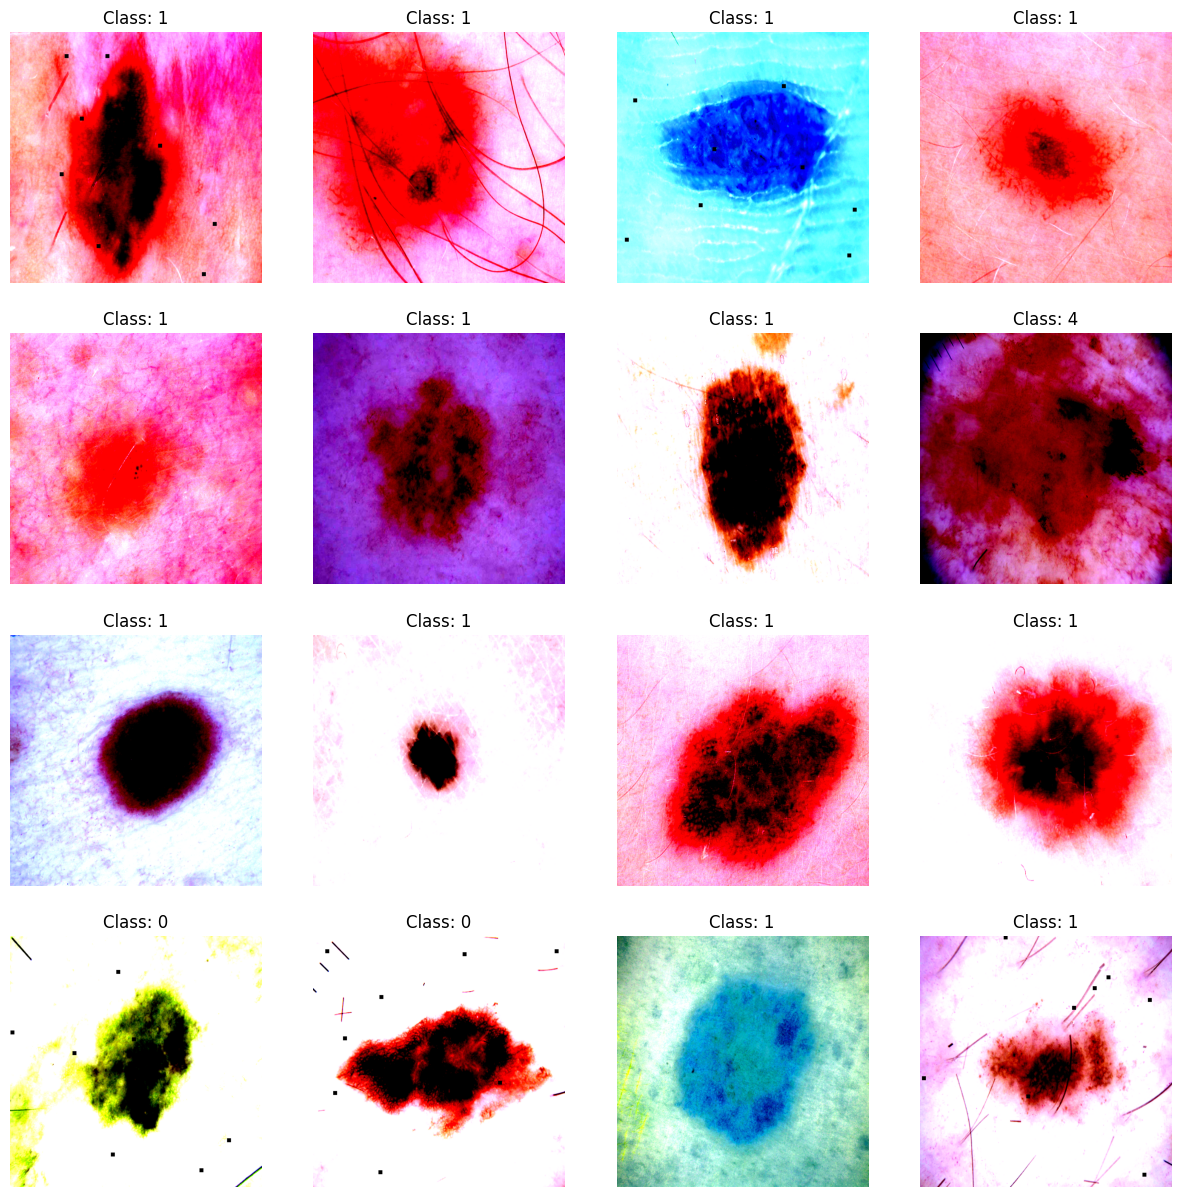

In [30]:
augs = ImageAugmentations(Config.input_size, apply_augs=True)
ds = GCDataset(train_csv, augmentations=augs.train_augs())
loader = torch.utils.data.DataLoader(ds,
                                     shuffle=True,
                                     batch_size=16)
images, labels = next(iter(loader))
plt.figure(figsize=(15, 15))
for step, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, step+1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f'Class: {int(label)}')

In [31]:
class GCModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super(GCModel, self).__init__()
        self.cfg = cfg
        timm_model = timm.create_model(self.cfg.model_name, 
                                       pretrained=pretrained, 
                                       in_chans=3)
        
        if self.cfg.freeze_backbone:
            modules = []
            for module in timm_model.children():
                for param in module.parameters():
                    param.requires_grad = False
                modules.append(module)
        else:
            modules = list(timm_model.children())
        
        self.classifier = modules[-1]
        cnn_out_features = self.classifier.in_features
        classifier_out_features = self.classifier.out_features
        
        self.cnn = nn.Sequential(*modules[:-1])
        self.dropout = nn.Dropout(0.2)
        
        self.classifier = nn.Sequential(nn.Linear(cnn_out_features, 64),
                                        nn.ReLU(),
                                        nn.Linear(64, cfg.targets))
        
    def forward(self, img):
        cnn_features = self.cnn(img)
        cnn_features = self.dropout(cnn_features)
        return self.classifier(cnn_features)

### Lightning Module

In [32]:
class LitGC(pl.LightningModule):
    def __init__(self, cfg, model, fold, class_weights: torch.Tensor = None,):
        super(LitGC, self).__init__()
        self.cfg = cfg
        self.model = model
        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()
        self.auc = metrics.classification.MulticlassAUROC(num_classes=cfg.targets)
        self.acc = metrics.Accuracy(task="multiclass", num_classes=cfg.targets, average='macro')
        self.fold = fold
        self.val_outputs = []
        self.train_outputs = []
        
    def forward(self, img):
        return self.model(img)

    def configure_optimizers(self):
        self.optimizer = self.__get_optimizer()
        self.lr_scheduler = self.__get_lr_scheduler()
        return {'optimizer': self.optimizer, 'lr_scheduler': self.lr_scheduler}
    
    def training_step(self, batch, batch_idx):
        img, y = batch
        y_hat = self(img)
        loss = self.criterion(y_hat, y)
        auc = self.auc(y_hat, y)
        acc = self.acc(y_hat, y)
        logs = {'train_loss': loss, 
                'train_auc': auc,
                'train_acc': acc,
                'lr': self.optimizer.param_groups[0]['lr']}
        self.train_outputs.append(logs)
        self.log_dict(
            logs,
            on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def on_train_epoch_end(self):
        outputs = self.train_outputs
        auc = torch.stack([x['train_auc'] for x in outputs]).mean()
        loss = torch.stack([x['train_loss'] for x in outputs]).mean()
        acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        lr = [x['lr'] for x in outputs][-1]
        print(f'Train | LR: {lr} : Epoch {self.current_epoch} : Fold {self.fold} -> loss: {loss}\t AUC: {auc}\t Accuracy: {acc}')
        return outputs
    
    def validation_step(self, batch, batch_idx):
        img, y = batch
        y_hat = self(img)
        loss = self.criterion(y_hat, y)
        auc = self.auc(y_hat, y)
        acc = self.acc(y_hat, y)
        logs = {'val_loss': loss, 
                'val_auc': auc,
                'val_acc': acc}
        self.val_outputs.append(logs)
        self.log_dict(
            logs,
            on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return logs
    
    def on_validation_epoch_end(self):
        outputs = self.val_outputs
        auc = torch.stack([x['val_auc'] for x in outputs]).mean()
        loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        print(f'Validation | Epoch {self.current_epoch} : Fold {self.fold} -> loss: {loss}\t AUC: {auc}\t Accuracy: {acc}')
        return outputs
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        if isinstance(batch, list):
            img, _ = batch
        else:
            img = batch
        out = self(img)
        return out

    def __get_optimizer(self):
        optimizer = None
        if self.cfg.optimizer == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.cfg.lr, 
                                         weight_decay=self.cfg.weight_decay, 
                                         amsgrad=False)
        elif self.cfg.optimizer == 'adamw':
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, 
                                          weight_decay=self.cfg.weight_decay)
        return optimizer

    def __get_lr_scheduler(self):
        scheduler = None
        if self.cfg.lr_scheduler=='ReduceLROnPlateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', 
                                                                   factor=self.cfg.factor, 
                                                                   patience=self.cfg.patience, 
                                                                   eps=self.cfg.eps)
        elif self.cfg.lr_scheduler=='CosineAnnealingLR':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 
                                                                   T_max=self.cfg.T_max, 
                                                                   eta_min=self.cfg.min_lr, 
                                                                   last_epoch=-1)
        elif self.cfg.lr_scheduler=='CosineAnnealingWarmRestarts':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer,
                                                                             T_0=self.cfg.T_0,
                                                                             eta_min=self.cfg.min_lr,
                                                                             last_epoch=-1)
        return scheduler

### Lightning data module

In [33]:
class GCDataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_files, 
                 val_files,
                 batch_size: int = 32,
                 image_size: int = Config.input_size,
                 apply_augmentations: bool = False):
        super(GCDataModule, self).__init__()
        self.train_files = train_files
        self.val_files = val_files
        self.batch_size = batch_size
        self.augs = ImageAugmentations(image_size, apply_augs=apply_augmentations)

    def setup(self, stage=None):
        self.train_ds = GCDataset(self.train_files,
                                augmentations=self.augs.train_augs(),
                                test=False)
        self.val_ds = GCDataset(self.val_files,
                                augmentations=self.augs.valid_augs(),
                                test=False)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds,
                                           shuffle=True,
                                           num_workers=Config.num_workers, 
                                           pin_memory=True,
                                           drop_last=True,
                                           batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds,
                                           shuffle=False,
                                           num_workers=Config.num_workers, 
                                           pin_memory=True,
                                           drop_last=False,
                                           batch_size=self.batch_size*2)

In [34]:
def model_checkpointing_callbacks(fold):
    return [pl.callbacks.ModelCheckpoint(monitor='val_loss',
                                         dirpath="./",
                                         save_top_k=1, 
                                         save_last=False, 
                                         save_weights_only=True, 
                                         filename=f'best/{Config.model_name}_best_loss_fold{fold}', 
                                         verbose=True, 
                                         mode='min'),
            pl.callbacks.ModelCheckpoint(monitor='val_auc',
                                         dirpath="./",
                                         save_top_k=1, 
                                         save_last=False, 
                                         save_weights_only=True, 
                                         filename=f'best/{Config.model_name}_best_auc_fold{fold}', 
                                         verbose=True,
                                         mode='max'),
           pl.callbacks.ModelCheckpoint(monitor='val_acc',
                                         dirpath="./",
                                         save_top_k=1, 
                                         save_last=False, 
                                         save_weights_only=True, 
                                         filename=f'best/{Config.model_name}_best_acc_fold{fold}', 
                                         verbose=True,
                                         mode='max')]

In [35]:
def get_loggers(fold):
    if Config.loggers:
        return [pl.loggers.CSVLogger("logs", name=f"{Config.model_name}_fold{fold}")]
    return None

# Training

### Finding class weights for calculating cross entropy loss

In [36]:
class_weights_dict = {}
total_samples = len(train_csv)
for key, count in class_counts.items():
    class_weights_dict[key] = total_samples / (len(class_counts) * count)
class_weights_dict =  dict(sorted(class_weights_dict.items()))
"Class weights are", class_weights_dict

('Class weights are',
 {0: 1.3511611541168191,
  1: 0.21239407951503353,
  2: 2.7705627705627704,
  3: 4.193971166448231,
  4: 1.2999322951929586,
  5: 12.13653603034134,
  6: 9.937888198757763})

In [37]:
class_weights = torch.tensor([x for _, x in class_weights_dict.items()], 
                             dtype=torch.float32)
"Class weights tensor", class_weights

('Class weights tensor',
 tensor([ 1.3512,  0.2124,  2.7706,  4.1940,  1.2999, 12.1365,  9.9379]))

In [38]:
if Config.train:
    cv = CrossValidation(train_csv, shuffle=True, random_state=Config.seed)
    for fold, (train_, val_) in enumerate(cv.kfold_split(splits=Config.n_fold)):
        if fold in Config.trn_folds:
            print(f"{'='*10} Fold {fold} {'='*10}")
            datamodule = GCDataModule(train_, 
                                      val_,
                                      batch_size=Config.batch_size,
                                      apply_augmentations=True)
            datamodule.setup()
            loggers = get_loggers(fold)
            callbacks = [pl.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=Config.patience, 
                                                    mode='min')]
            model = GCModel(Config, pretrained=True)
            checkpoint_callbacks = model_checkpointing_callbacks(fold)
            lit = LitGC(Config, model, fold=fold, class_weights=class_weights)
            trainer_params = {"max_epochs": Config.epochs,
                              "accumulate_grad_batches": Config.gradient_accumulation_steps,
                              "precision": Config.precision,
                              "callbacks": callbacks+checkpoint_callbacks,
                              "logger": loggers}
            trainer = pl.Trainer(**trainer_params)
            # Train the model
            trainer.fit(lit, datamodule)

========== Fold 0 ==========


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 0 -> loss: 1.9420738220214844	 AUC: 0.192735493183136	 Accuracy: 0.1462053656578064


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 0 -> loss: 0.8525068759918213	 AUC: 0.6522693037986755	 Accuracy: 0.560658872127533
Train | LR: 0.0001 : Epoch 0 : Fold 0 -> loss: 1.3995811939239502	 AUC: 0.49379149079322815	 Accuracy: 0.38741588592529297


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 1 : Fold 0 -> loss: 0.7161402702331543	 AUC: 0.6664119362831116	 Accuracy: 0.6210010647773743
Train | LR: 9.757729755661011e-05 : Epoch 1 : Fold 0 -> loss: 1.088435411453247	 AUC: 0.5233767032623291	 Accuracy: 0.47323077917099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 2 : Fold 0 -> loss: 0.6404702663421631	 AUC: 0.6744747757911682	 Accuracy: 0.6514327526092529
Train | LR: 9.05463412215599e-05 : Epoch 2 : Fold 0 -> loss: 0.9146910309791565	 AUC: 0.5357145071029663	 Accuracy: 0.5294137597084045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 3 : Fold 0 -> loss: 0.6056753396987915	 AUC: 0.6786270141601562	 Accuracy: 0.6690337061882019
Train | LR: 7.959536998847742e-05 : Epoch 3 : Fold 0 -> loss: 0.7884169816970825	 AUC: 0.5446903705596924	 Accuracy: 0.5771871209144592


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 4 : Fold 0 -> loss: 0.5716729760169983	 AUC: 0.6819235682487488	 Accuracy: 0.6896460056304932
Train | LR: 6.57963412215599e-05 : Epoch 4 : Fold 0 -> loss: 0.6899920701980591	 AUC: 0.5509319305419922	 Accuracy: 0.6150200366973877


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 5 : Fold 0 -> loss: 0.5446276068687439	 AUC: 0.6842774152755737	 Accuracy: 0.7086238265037537
Train | LR: 5.05e-05 : Epoch 5 : Fold 0 -> loss: 0.6163280010223389	 AUC: 0.5543856024742126	 Accuracy: 0.6496523022651672


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 6 : Fold 0 -> loss: 0.5224009156227112	 AUC: 0.6863818764686584	 Accuracy: 0.7234952449798584
Train | LR: 3.5203658778440106e-05 : Epoch 6 : Fold 0 -> loss: 0.5554997324943542	 AUC: 0.5581949353218079	 Accuracy: 0.6773600578308105


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 7 : Fold 0 -> loss: 0.5095070600509644	 AUC: 0.687930703163147	 Accuracy: 0.7340061664581299
Train | LR: 2.1404630011522586e-05 : Epoch 7 : Fold 0 -> loss: 0.5063239932060242	 AUC: 0.5615285038948059	 Accuracy: 0.7004368305206299


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 8 : Fold 0 -> loss: 0.4975948631763458	 AUC: 0.6890522241592407	 Accuracy: 0.7423601150512695
Train | LR: 1.0453658778440109e-05 : Epoch 8 : Fold 0 -> loss: 0.46583351492881775	 AUC: 0.5640773177146912	 Accuracy: 0.7192375659942627


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 9 : Fold 0 -> loss: 0.48906800150871277	 AUC: 0.6900942921638489	 Accuracy: 0.7496162056922913
Train | LR: 3.4227024433899e-06 : Epoch 9 : Fold 0 -> loss: 0.43103140592575073	 AUC: 0.5666399002075195	 Accuracy: 0.7370242476463318


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 10 : Fold 0 -> loss: 0.49184516072273254	 AUC: 0.6906838417053223	 Accuracy: 0.7524282932281494
Train | LR: 0.0001 : Epoch 10 : Fold 0 -> loss: 0.41370144486427307	 AUC: 0.5671766400337219	 Accuracy: 0.744341254234314
========== Fold 1 ==========


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 1 -> loss: 1.959380865097046	 AUC: 0.3726186156272888	 Accuracy: 0.02336956560611725


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 1 -> loss: 0.8433355093002319	 AUC: 0.6974332332611084	 Accuracy: 0.5792942047119141
Train | LR: 0.0001 : Epoch 0 : Fold 1 -> loss: 1.3892934322357178	 AUC: 0.49211040139198303	 Accuracy: 0.39867129921913147


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 1 : Fold 1 -> loss: 0.7141101360321045	 AUC: 0.7122388482093811	 Accuracy: 0.6355959177017212
Train | LR: 9.757729755661011e-05 : Epoch 1 : Fold 1 -> loss: 1.102388858795166	 AUC: 0.5185994505882263	 Accuracy: 0.47525426745414734


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 2 : Fold 1 -> loss: 0.642911970615387	 AUC: 0.7196042537689209	 Accuracy: 0.6742565631866455
Train | LR: 9.05463412215599e-05 : Epoch 2 : Fold 1 -> loss: 0.9248965978622437	 AUC: 0.5309398770332336	 Accuracy: 0.5329888463020325


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 3 : Fold 1 -> loss: 0.6146153211593628	 AUC: 0.7235816121101379	 Accuracy: 0.6940706372261047
Train | LR: 7.959536998847742e-05 : Epoch 3 : Fold 1 -> loss: 0.8026400804519653	 AUC: 0.5395479202270508	 Accuracy: 0.5751174092292786


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 4 : Fold 1 -> loss: 0.5890322923660278	 AUC: 0.7264642119407654	 Accuracy: 0.7101981043815613
Train | LR: 6.57963412215599e-05 : Epoch 4 : Fold 1 -> loss: 0.705886960029602	 AUC: 0.5448876023292542	 Accuracy: 0.6132466793060303


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 5 : Fold 1 -> loss: 0.5778700709342957	 AUC: 0.728203535079956	 Accuracy: 0.7137501835823059
Train | LR: 5.05e-05 : Epoch 5 : Fold 1 -> loss: 0.6302698254585266	 AUC: 0.5491891503334045	 Accuracy: 0.6470429301261902


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 6 : Fold 1 -> loss: 0.5711447596549988	 AUC: 0.7302866578102112	 Accuracy: 0.7269441485404968
Train | LR: 3.5203658778440106e-05 : Epoch 6 : Fold 1 -> loss: 0.5713061094284058	 AUC: 0.5522909760475159	 Accuracy: 0.6733168363571167


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 7 : Fold 1 -> loss: 0.5632920861244202	 AUC: 0.732023298740387	 Accuracy: 0.7351152300834656
Train | LR: 2.1404630011522586e-05 : Epoch 7 : Fold 1 -> loss: 0.5200684070587158	 AUC: 0.5554242730140686	 Accuracy: 0.697733998298645


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 8 : Fold 1 -> loss: 0.5567371249198914	 AUC: 0.7333934903144836	 Accuracy: 0.7403587102890015
Train | LR: 1.0453658778440109e-05 : Epoch 8 : Fold 1 -> loss: 0.47800710797309875	 AUC: 0.5575604438781738	 Accuracy: 0.7173083424568176
========== Fold 2 ==========


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 2 -> loss: 1.9134998321533203	 AUC: 0.36157137155532837	 Accuracy: 0.15833333134651184


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 2 -> loss: 0.8510537147521973	 AUC: 0.6853381395339966	 Accuracy: 0.5792148113250732
Train | LR: 0.0001 : Epoch 0 : Fold 2 -> loss: 1.3211674690246582	 AUC: 0.4978989362716675	 Accuracy: 0.3878217935562134


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 1 : Fold 2 -> loss: 0.7542095184326172	 AUC: 0.7024695873260498	 Accuracy: 0.6035798788070679
Train | LR: 9.757729755661011e-05 : Epoch 1 : Fold 2 -> loss: 1.0629775524139404	 AUC: 0.5194939374923706	 Accuracy: 0.47074151039123535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 2 : Fold 2 -> loss: 0.6611455678939819	 AUC: 0.707913339138031	 Accuracy: 0.6411422491073608
Train | LR: 9.05463412215599e-05 : Epoch 2 : Fold 2 -> loss: 0.8910115957260132	 AUC: 0.5309131145477295	 Accuracy: 0.5321055054664612


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 3 : Fold 2 -> loss: 0.6044643521308899	 AUC: 0.7126128077507019	 Accuracy: 0.6724212169647217
Train | LR: 7.959536998847742e-05 : Epoch 3 : Fold 2 -> loss: 0.7763286828994751	 AUC: 0.5398707985877991	 Accuracy: 0.5793917775154114


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 4 : Fold 2 -> loss: 0.5753881931304932	 AUC: 0.7155026793479919	 Accuracy: 0.6881175637245178
Train | LR: 6.57963412215599e-05 : Epoch 4 : Fold 2 -> loss: 0.688206672668457	 AUC: 0.5466675162315369	 Accuracy: 0.6169611811637878


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 5 : Fold 2 -> loss: 0.5487281680107117	 AUC: 0.7183773517608643	 Accuracy: 0.7064425945281982
Train | LR: 5.05e-05 : Epoch 5 : Fold 2 -> loss: 0.6167263984680176	 AUC: 0.5506342053413391	 Accuracy: 0.6485249996185303


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 6 : Fold 2 -> loss: 0.5281375646591187	 AUC: 0.7205148339271545	 Accuracy: 0.7231717705726624
Train | LR: 3.5203658778440106e-05 : Epoch 6 : Fold 2 -> loss: 0.558198869228363	 AUC: 0.552937388420105	 Accuracy: 0.6755861639976501


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 7 : Fold 2 -> loss: 0.514041006565094	 AUC: 0.7221626043319702	 Accuracy: 0.7367104291915894
Train | LR: 2.1404630011522586e-05 : Epoch 7 : Fold 2 -> loss: 0.5076897740364075	 AUC: 0.555493950843811	 Accuracy: 0.6995018124580383


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 8 : Fold 2 -> loss: 0.5001843571662903	 AUC: 0.7235393524169922	 Accuracy: 0.7460368871688843
Train | LR: 1.0453658778440109e-05 : Epoch 8 : Fold 2 -> loss: 0.4682123064994812	 AUC: 0.5575463175773621	 Accuracy: 0.7190801501274109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 9 : Fold 2 -> loss: 0.490937739610672	 AUC: 0.7246467471122742	 Accuracy: 0.7540872693061829
Train | LR: 3.4227024433899e-06 : Epoch 9 : Fold 2 -> loss: 0.4336364269256592	 AUC: 0.5599579811096191	 Accuracy: 0.73602294921875


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 10 : Fold 2 -> loss: 0.4948493540287018	 AUC: 0.7254122495651245	 Accuracy: 0.7555511593818665
Train | LR: 0.0001 : Epoch 10 : Fold 2 -> loss: 0.41735607385635376	 AUC: 0.5610299110412598	 Accuracy: 0.7433204054832458


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 11 : Fold 2 -> loss: 0.4970013201236725	 AUC: 0.7258917689323425	 Accuracy: 0.758216381072998
Train | LR: 9.757729755661011e-05 : Epoch 11 : Fold 2 -> loss: 0.4006558060646057	 AUC: 0.5626136064529419	 Accuracy: 0.7505649328231812


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 12 : Fold 2 -> loss: 0.4974089562892914	 AUC: 0.726370632648468	 Accuracy: 0.762362003326416
Train | LR: 9.05463412215599e-05 : Epoch 12 : Fold 2 -> loss: 0.3842201828956604	 AUC: 0.563734233379364	 Accuracy: 0.7581663131713867
========== Fold 3 ==========


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 3 -> loss: 1.9640061855316162	 AUC: 0.3205694556236267	 Accuracy: 0.0714285746216774


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 3 -> loss: 0.9566323757171631	 AUC: 0.6544318795204163	 Accuracy: 0.5399163961410522
Train | LR: 0.0001 : Epoch 0 : Fold 3 -> loss: 1.3272031545639038	 AUC: 0.4983634948730469	 Accuracy: 0.4226337671279907


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 1 : Fold 3 -> loss: 0.7536048889160156	 AUC: 0.6757746934890747	 Accuracy: 0.6175655722618103
Train | LR: 9.757729755661011e-05 : Epoch 1 : Fold 3 -> loss: 1.0472612380981445	 AUC: 0.5206409692764282	 Accuracy: 0.4914468824863434


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 2 : Fold 3 -> loss: 0.6817238926887512	 AUC: 0.683911919593811	 Accuracy: 0.6578922867774963
Train | LR: 9.05463412215599e-05 : Epoch 2 : Fold 3 -> loss: 0.8741799592971802	 AUC: 0.5338544845581055	 Accuracy: 0.548439621925354


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 3 : Fold 3 -> loss: 0.6186464428901672	 AUC: 0.6895572543144226	 Accuracy: 0.6879501938819885
Train | LR: 7.959536998847742e-05 : Epoch 3 : Fold 3 -> loss: 0.7567152976989746	 AUC: 0.5418094396591187	 Accuracy: 0.5934293270111084


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 4 : Fold 3 -> loss: 0.5988670587539673	 AUC: 0.6927587985992432	 Accuracy: 0.7045661807060242
Train | LR: 6.57963412215599e-05 : Epoch 4 : Fold 3 -> loss: 0.6644442081451416	 AUC: 0.5465847849845886	 Accuracy: 0.6303679347038269


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 5 : Fold 3 -> loss: 0.577278196811676	 AUC: 0.6950978636741638	 Accuracy: 0.7184828519821167
Train | LR: 5.05e-05 : Epoch 5 : Fold 3 -> loss: 0.5924716591835022	 AUC: 0.5505701303482056	 Accuracy: 0.6599247455596924


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 6 : Fold 3 -> loss: 0.5622977018356323	 AUC: 0.6971441507339478	 Accuracy: 0.7318174242973328
Train | LR: 3.5203658778440106e-05 : Epoch 6 : Fold 3 -> loss: 0.5339392423629761	 AUC: 0.5537200570106506	 Accuracy: 0.6873299479484558


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 7 : Fold 3 -> loss: 0.5485190749168396	 AUC: 0.6987981796264648	 Accuracy: 0.740943193435669
Train | LR: 2.1404630011522586e-05 : Epoch 7 : Fold 3 -> loss: 0.4871917963027954	 AUC: 0.5563367605209351	 Accuracy: 0.7085071802139282
========== Fold 4 ==========


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 4 -> loss: 1.9535728693008423	 AUC: 0.349173367023468	 Accuracy: 0.10476191341876984


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 0 : Fold 4 -> loss: 0.8688926100730896	 AUC: 0.6830824613571167	 Accuracy: 0.6232261657714844
Train | LR: 0.0001 : Epoch 0 : Fold 4 -> loss: 1.3963124752044678	 AUC: 0.49255311489105225	 Accuracy: 0.4145197868347168


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 1 : Fold 4 -> loss: 0.7455084919929504	 AUC: 0.6942594647407532	 Accuracy: 0.6710230708122253
Train | LR: 9.757729755661011e-05 : Epoch 1 : Fold 4 -> loss: 1.0903350114822388	 AUC: 0.5224255323410034	 Accuracy: 0.4900803565979004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 2 : Fold 4 -> loss: 0.6912375092506409	 AUC: 0.6996099352836609	 Accuracy: 0.6802955865859985
Train | LR: 9.05463412215599e-05 : Epoch 2 : Fold 4 -> loss: 0.911999523639679	 AUC: 0.5361859798431396	 Accuracy: 0.5450645685195923


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 3 : Fold 4 -> loss: 0.6564679741859436	 AUC: 0.7044529318809509	 Accuracy: 0.6928825378417969
Train | LR: 7.959536998847742e-05 : Epoch 3 : Fold 4 -> loss: 0.7867743968963623	 AUC: 0.5441477298736572	 Accuracy: 0.591450035572052


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 4 : Fold 4 -> loss: 0.6251038908958435	 AUC: 0.7074814438819885	 Accuracy: 0.7095019817352295
Train | LR: 6.57963412215599e-05 : Epoch 4 : Fold 4 -> loss: 0.6946782469749451	 AUC: 0.5501040816307068	 Accuracy: 0.6281286478042603


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 5 : Fold 4 -> loss: 0.5952768921852112	 AUC: 0.7097412943840027	 Accuracy: 0.7249205708503723
Train | LR: 5.05e-05 : Epoch 5 : Fold 4 -> loss: 0.618908703327179	 AUC: 0.5532833933830261	 Accuracy: 0.6597433090209961


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 6 : Fold 4 -> loss: 0.5716172456741333	 AUC: 0.7117646336555481	 Accuracy: 0.7377483248710632
Train | LR: 3.5203658778440106e-05 : Epoch 6 : Fold 4 -> loss: 0.5568230748176575	 AUC: 0.5566019415855408	 Accuracy: 0.6860784292221069


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 7 : Fold 4 -> loss: 0.5572401881217957	 AUC: 0.7132366299629211	 Accuracy: 0.7474702596664429
Train | LR: 2.1404630011522586e-05 : Epoch 7 : Fold 4 -> loss: 0.5053370594978333	 AUC: 0.5589386224746704	 Accuracy: 0.708912193775177


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 8 : Fold 4 -> loss: 0.5469287037849426	 AUC: 0.71449875831604	 Accuracy: 0.7569479942321777
Train | LR: 1.0453658778440109e-05 : Epoch 8 : Fold 4 -> loss: 0.46342548727989197	 AUC: 0.5610265135765076	 Accuracy: 0.7282457947731018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 9 : Fold 4 -> loss: 0.5380991697311401	 AUC: 0.7154911160469055	 Accuracy: 0.7643319964408875
Train | LR: 3.4227024433899e-06 : Epoch 9 : Fold 4 -> loss: 0.4293767809867859	 AUC: 0.5633226633071899	 Accuracy: 0.7446779608726501


Validation: |          | 0/? [00:00<?, ?it/s]

Validation | Epoch 10 : Fold 4 -> loss: 0.5506853461265564	 AUC: 0.7155139446258545	 Accuracy: 0.764758825302124
Train | LR: 0.0001 : Epoch 10 : Fold 4 -> loss: 0.41149407625198364	 AUC: 0.5641434788703918	 Accuracy: 0.7513493299484253


# Inference

In [39]:
def get_weights_path(fold, mode):
    return os.path.join("best", f"{Config.model_name}_best_{mode}_fold{fold}.ckpt")

In [40]:
def get_fold_predictions(fold, data, ensemble_fn=None, logits=False):
    print("="*10)
    print("Predictions using Fold: ", fold)
    print("="*10)
    augs = ImageAugmentations(Config.input_size, apply_augs=False)
    ds = GCDataset(data,
                   augmentations=augs.valid_augs(),
                   test=False)
    weights = [get_weights_path(fold, "loss"),
               get_weights_path(fold, "auc"),
               get_weights_path(fold, "acc")]
    preds = []
    for weight in weights:
        print("Using weights: ", weight)
        loader = torch.utils.data.DataLoader(ds,
                                             shuffle=False,
                                             num_workers=Config.num_workers, 
                                             pin_memory=True,
                                             drop_last=False,
                                             batch_size=Config.batch_size*2)
        model = GCModel(Config, pretrained=False)
        lit = LitGC.load_from_checkpoint(weight, cfg=Config, model=model, fold=fold, class_weights=class_weights)
        trainer = pl.Trainer()
        predictions = trainer.predict(lit, loader)
        predictions = torch.cat([x for x in predictions]).detach().cpu().numpy()
        preds.append(predictions)
    if ensemble_fn is not None:
        preds = ensemble_fn(preds, logits=logits)
    return preds

In [41]:
def get_test_fold_predictions(fold, test_csv, tta_steps=0, ensemble_fn=None, logits=False):
    print("="*10)
    print("Predictions using fold", fold)
    print("="*10)
    augs = ImageAugmentations(Config.input_size, apply_augs=True)
    weights = [get_weights_path(fold, "loss"),
               get_weights_path(fold, "auc"),
               get_weights_path(fold, "acc")]
    preds = []
    for weight in weights:
        print("Using weights: ", weight)
        model = GCModel(Config, pretrained=False)
        lit = LitGC.load_from_checkpoint(weight, cfg=Config, model=model, fold=fold, class_weights=class_weights)
        trainer = pl.Trainer()
        for tta in range(tta_steps):
            if tta == 0:
                ds = GCDataset(test_csv,
                               augmentations=augs.valid_augs(),
                               test=True)
            else:
                ds = GCDataset(test_csv,
                               augmentations=augs.train_augs(),
                               test=True)
            loader = torch.utils.data.DataLoader(ds,
                                                 shuffle=False,
                                                 num_workers=Config.num_workers, 
                                                 pin_memory=True,
                                                 drop_last=False,
                                                 batch_size=Config.batch_size*2)
            predictions = trainer.predict(lit, loader)
            predictions = torch.cat([x for x in predictions]).detach().cpu().numpy()
            preds.append(predictions)
    if ensemble_fn is not None:
        preds = ensemble_fn(preds, logits=logits)
    return preds

In [42]:
def geometric_mean_ensembling(predictions, logits=False):
    if logits:
        return gmean(predictions, axis=0)
    return np.argmax(gmean(predictions, axis=0), axis=1)

In [43]:
def rank_average_ensembling(predictions, mode="average", logits=False):
    def __check_rank_modes(mode):
        modes = ["average", "min", "max", "dense", "ordinal"]
        if mode not in modes:
            raise Exception(f"mode send is not defined use any of {modes}")
    __check_rank_modes(mode)
    predictions = rankdata(predictions, method=mode, axis=1)
    if logits:
        return np.mean(predictions, axis=0)
    return np.argmax(np.mean(predictions, axis=0), axis=1)

In [44]:
def voting_ensembling(predictions, voting="hard", input_logits=True, *args, **kwargs):
    if voting=="hard":
        if input_logits:
            predictions = np.argmax(predictions, axis=2)
        predictions, _ = mode(predictions, axis=0)
        return predictions
    elif voting=="soft":
        if input_logits == False:
            raise Exception("logits cannot be False for soft voting")
        predictions = np.mean(predictions, axis=0)
        predictions = np.argmax(predictions, axis=2)
        return predictions
    else:
        raise Exception("voting type not defined choose from [hard, soft]")

In [45]:
logits = []
targets = []
oof_df = pd.DataFrame()
cv = CrossValidation(train_csv, shuffle=True, random_state=Config.seed)
for fold, (_, val_) in enumerate(cv.kfold_split(splits=Config.n_fold)):
    if fold in Config.trn_folds:
        _oof_df = pd.DataFrame()
        _oof_df["image"] = val_["image"]
        _oof_df["classes"] = val_["classes"]
        preds_logits = get_fold_predictions(fold, val_, rank_average_ensembling, logits=True)
        _oof_df["predictions"] = np.argmax(preds_logits, axis=1)
        _oof_df["logits"] = [" ".join(str(x)) for x in preds_logits.tolist()]
        _oof_df["probability"] = [" ".join(str(x)) for x in torch.softmax(torch.tensor(preds_logits), dim=1).tolist()]
        logits.append(preds_logits)
        targets.append(val_["classes"])
        oof_df = pd.concat([oof_df, _oof_df])
oof_df.to_csv(f"oof_{Config.model_name}.csv", index=False)

Predictions using Fold:  0
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold0.ckpt


2024-03-11 12:58:21.478872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 12:58:21.479010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 12:58:21.637535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using Fold:  1
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using Fold:  2
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using Fold:  3
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using Fold:  4
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
logits = torch.from_numpy(np.array(logits).reshape(-1, 7))
targets = torch.from_numpy(np.array(targets).reshape(-1))

In [47]:
auc_metrics = metrics.classification.MulticlassAUROC(num_classes=Config.targets)
acc_metrics = metrics.Accuracy(task="multiclass", num_classes=Config.targets, average='macro')

In [48]:
auc_score = auc_metrics(logits, targets)
acc_score = acc_metrics(logits, targets)
print("Accuracy Score for Whole Dataset with cross validation: ", acc_score.item())
print("AUC Score for Whole Dataset with cross validation: ", auc_score.item())

Accuracy Score for Whole Dataset with cross validation:  0.7831358313560486
AUC Score for Whole Dataset with cross validation:  0.9253316521644592


In [49]:
oof = pd.read_csv(f"oof_{Config.model_name}.csv")
oof.head()

image  classes  predictions  \
0  ISIC_0025624        1            6   
1  ISIC_0029697        1            4   
2  ISIC_0024989        1            3   
3  ISIC_0024652        0            0   
4  ISIC_0031787        1            5   

                                              logits  \
0  [ 4 2 3 . 3 3 3 3 3 3 3 3 3 3 3 3 3 ,   1 6 7 ...   
1  [ 1 0 3 6 . 6 6 6 6 6 6 6 6 6 6 6 6 7 ,   1 1 ...   
2  [ 5 3 4 . 6 6 6 6 6 6 6 6 6 6 6 6 6 ,   7 9 5 ...   
3  [ 1 8 2 9 . 6 6 6 6 6 6 6 6 6 6 6 6 7 ,   3 7 ...   
4  [ 7 6 . 0 ,   1 5 5 1 . 6 6 6 6 6 6 6 6 6 6 6 ...   

                                         probability  
0  [ 0 . 0 ,   6 . 8 4 7 0 0 6 7 6 4 7 4 3 0 0 8 ...  
1  [ 1 . 9 3 1 3 8 3 1 8 7 7 4 0 4 9 7 e - 8 7 , ...  
2  [ 0 . 0 ,   0 . 0 ,   3 . 4 6 4 1 0 0 4 5 5 9 ...  
3  [ 1 . 0 ,   0 . 0 ,   0 . 0 ,   0 . 0 ,   3 . ...  
4  [ 0 . 0 ,   3 . 9 0 3 6 5 3 9 2 8 1 4 2 8 6 1 ...

# Test Data Inference

fold logits to max votes

In [50]:
fold_test_predictions = []
for fold in Config.trn_folds:
    preds = get_test_fold_predictions(fold, test_csv, tta_steps=10, 
                                      ensemble_fn=rank_average_ensembling, 
                                      logits=True)
    fold_test_predictions.append(preds)
    
fold_test_predictions = np.array(fold_test_predictions)

Predictions using fold 0
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 1
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 2
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 3
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 4
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
test_predictions = voting_ensembling(fold_test_predictions, input_logits=True)

In [52]:
test_csv["Class"] = test_predictions
sub_csv = test_csv[["ID", "Class"]]
sub_csv.to_csv("submission.csv", index=False)
sub_csv.head()

ID  Class
0  ISIC_0034524      1
1  ISIC_0034525      5
2  ISIC_0034526      3
3  ISIC_0034527      6
4  ISIC_0034528      4

labels to max voting for each fold

In [53]:
fold_test_predictions = []
for fold in Config.trn_folds:
    preds = get_test_fold_predictions(fold, test_csv, tta_steps=10, 
                                      ensemble_fn=rank_average_ensembling, 
                                      logits=False)
    fold_test_predictions.append(preds)
    
fold_test_predictions = np.array(fold_test_predictions)

Predictions using fold 0
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold0.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 1
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 2
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 3
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions using fold 4
Using weights:  best/tf_efficientnet_b3_ns_best_loss_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_auc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Using weights:  best/tf_efficientnet_b3_ns_best_acc_fold4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [54]:
test_predictions = voting_ensembling(fold_test_predictions, input_logits=False)

In [55]:
test_csv["Class"] = test_predictions
sub_csv = test_csv[["ID", "Class"]]
sub_csv.to_csv("submission_1.csv", index=False)
sub_csv.head()

ID  Class
0  ISIC_0034524      1
1  ISIC_0034525      5
2  ISIC_0034526      3
3  ISIC_0034527      0
4  ISIC_0034528      4